# CythonによるC/C++とPythonの連携 #

* 大橋 宏正
* twitter: @wrist

## 自己紹介 ##

* 音響信号処理が専門のエンジニア
    * 某メーカー勤務
    * 収音系処理(マイクロホン)がメイン
* よく使うScipy
    * fftpack
    * signal

## 宣伝 ##

* 書籍「行列プログラマー」のオンライン読書会をやっています
* https://osaka-prml-reading.connpass.com/event/48885/
* 毎週土曜夜21:00-23:00に開催
* トチ狂って本日21時からもやることになっています

## 本日の資料 ##

* https://github.com/wrist/pydata-osaka3

## 本日の内容 ##

* Cythonの概要
* Cythonの動作およびビルド方法
* `%%cython`マジックコマンドによるJupyter notebook上での高速化
    * アノテーションによるボトルネックの改善
* Cコード(`libsndfile`)に対するラッパー作成
* 時間がないためC++コードに対するラッパー作成方法の紹介については割愛

## 今回の発表の背景 ##

* 業務上Pythonでアルゴリズム検討の上、C/C++でプロトタイプ実装を行うことが多い
* 今回の発表の個人的な目的
    * アルゴリズム検討の高速化
        * 信号処理はサンプル/フレーム単位の積和処理ばかりだがPythonだとループが遅い
    * 既存C/C++資産の活用

## Cythonとは ##

* PythonとCを混在可能な言語
    * 静的型付けによる高速化の恩恵とPythonの書きやすさを両立
    * コンパイルするとPython/C APIを使用するC/C++コードを生成
    * 生成されたC/C++コードをビルドするとPythonから使用可能な拡張モジュールを生成
* 使用目的
    * 静的型付けによる最適化・高速化
    * C/C++とのグルー言語

## cython.orgのトップページから引用・意訳 ##

* http://cython.org/
*  CythonではPythonとCの融合によって以下のようなことを可能とする
    * C/C++で書かれたネイティブコードを呼ぶPythonコードを書く
    * 簡単に静的な型定義を可読性の高いPythonコードに加えることによってCのパフォーマンスを得る
    * 多次元Numpy配列のような大きなデータセットに対しても効率的なやり取りが可能
    * CPythonに対する広く成熟したエコシステムを活用可能
    * 既存のネイティブコードや、低レベル・ハイパフォ―マンスなライブラリやアプリを統合可能

## どこで使われているか ##

* オライリーのCython本P.71より引用
    * 2014年のデータなので現在は異なる筈
    * https://github.com/cython/cython/wiki/projects にも情報あり

<img src="./img/where_uses_cython.png" />

## インストール ##

* `pip install cython`
* `conda install cython`
    * anacondaなら最初から入っている筈

## Cythonの実際の例 ##

* フィボナッチ数列を求めるPythonコードをCython化
* `%%cython`マジックコマンドで手軽に試せる

In [1]:
# Pythonで書いたフィボナッチ数列
def fib(n):
    a, b = 0, 1
    for i in range(n):
        a, b = a + b,  a
    return a

In [2]:
fib(50)

12586269025

In [3]:
%timeit fib(50)

100000 loops, best of 3: 4.14 µs per loop


In [4]:
%load_ext cython

In [5]:
%%cython
# .pyxファイル(後述)の中身に相当
# ローカル変数はcdefで型定義が可能
# 引数は型を変数名の手前に書く
def c_fib(long n):
    cdef long i, a, b
    a, b = 0, 1
    for i in range(n):
        a, b = a + b, a
    return a

In [6]:
# python側から呼べる
c_fib(50)

12586269025

In [7]:
%timeit c_fib(50)

The slowest run took 20.43 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 108 ns per loop


## 動作イメージ ##

<img src="./img/build_flow.png" width="1200px" height="800px" />

## 手動でのコンパイルおよびビルド ##

* https://cython.readthedocs.io/en/latest/src/reference/compilation.html
* `cython`コマンドで`.pyx`ファイルをコンパイル
    * `cython -a yourmod.pyx`
* `.pyx`ファイルをダイナミックライブラリとしてビルド
    * `gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing \
      -I/usr/include/python2.7 -o yourmod.so yourmod.c`

In [8]:
%%writefile c_fib.pyx
def c_fib(long n):
    cdef long i, a, b
    a, b = 0, 1
    for i in range(n):
        a, b = a + b, a
    return a

Overwriting c_fib.pyx


In [9]:
# c_fib.pyxをcythonizeしてc_fib.cを生成
!cython c_fib.pyx

In [10]:
# c_fib.cが生成
# c_fib.cをダイナミックライブラリとして
# gccなどでビルドすることで拡張モジュールを作成可能
!ls

build                       img
c_fib.c                     pysndfile
c_fib.cpython-35m-darwin.so readme.md
c_fib.pyx                   rectangle
cython_and_c_wrapper.ipynb  setup.py
docker


## それ以外の代表的なビルド方法 ##

* IPythonの`%%cython`マジックコマンド(前述)
    * セルの内容をpyxファイルとみなしてその場でコンパイル
* `import pyximport; pyximport.install()`
    * 現在のディレクトリ配下にあるpyxファイルをコンパイル
    * 次スライドで説明
* ビルドスクリプト`setup.py`を記述
    * `python setup.py build_ext --inplace`

In [11]:
# %%cythonでの実行で作成されたc_fibを削除
del c_fib

In [12]:
# pyximportを使ってc_fib.pyxをコンパイル 
import pyximport
pyximport.install()  # => c_fib拡張モジュールが自動生成

# reloadする可能性がある場合は
# pyximport.install(reload_support=True)

(None, <pyximport.pyximport.PyxImporter at 0x1055ecb00>)

In [13]:
import c_fib
c_fib.c_fib(50)

12586269025

### `setup.py`を書く方法 ###

* setup.py

```python:setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension(name="c_fib",
                sources=["c_fib.pyx"])

setup(ext_modules=cythonize(ext))
```

* これをpythonで実行
```sh
python setup.py build_ext --inplace
```

In [14]:
%%writefile setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension(name="c_fib",
                sources=["c_fib.pyx"])

setup(ext_modules=cythonize(ext))

Overwriting setup.py


In [15]:
!python setup.py build_ext --inplace

running build_ext
building 'c_fib' extension
/usr/bin/clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wrist/.pyenv/versions/miniconda3-latest/envs/scientific/include -arch x86_64 -I/Users/wrist/.pyenv/versions/miniconda3-latest/envs/scientific/include/python3.5m -c c_fib.c -o build/temp.macosx-10.6-x86_64-3.5/c_fib.o
/usr/bin/clang -bundle -undefined dynamic_lookup -L/Users/wrist/.pyenv/versions/miniconda3-latest/envs/scientific/lib -arch x86_64 build/temp.macosx-10.6-x86_64-3.5/c_fib.o -L/Users/wrist/.pyenv/versions/miniconda3-latest/envs/scientific/lib -o /Users/wrist/work/pydata/20170121/c_fib.cpython-35m-darwin.so


In [25]:
# setup.pyの実行に成功すると.soが生成される
!ls

build                       img
c_fib.c                     pysndfile
c_fib.cpython-35m-darwin.so readme.md
c_fib.pyx                   rectangle
cython_and_c_wrapper.ipynb  setup.py
docker


# `%%cython`マジックコマンドによるJupyter上での高速化 #

## %%cython -a ##

* `%%cython -a`でpyxコンパイルとともにアノテーションファイルを表示可能
* Python/C APIの呼び出し回数が多い場所をハイライト
    * Cythonは呼び出しが多い箇所が遅いと判断
    * ハイライト箇所をクリックすると変換されたコードを見ることが可能
* オライリーのCython本9章の内容を元に高速化の流れを紹介

In [26]:
%%cython -a
# 高速化の対象となる関数(引数fをaからbまで積分)
def integrate(a, b, f, N=2000):
    dx = (a - b) / N
    s = 0.0
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

### 前スライドのコード ###

* 全ての行が濃い
* 3行目が遅い理由
    * `PyNumber_Subtract`, `__Pyx_PyNumber_Divide`
    * エラー処理や参照カウント
* 5行目のforループ
    * 40行近くある

## 型宣言を追加 ##

* 引数にdoubleを付ける
* `cdef`でローカル変数に型付
* `cdef`の使用方法
    * `cdef unsigned int a`
    * `cdef:`ブロック
    * ここでは出てこないがポインタなども宣言可能

In [18]:
%%cython -a
def typed_integrate(double a, double b, f, int N=2000):
    cdef:
        int i
        double dx = (b - a) / N
        double s = 0.0
    
    for i in range(N):
        s += f(a + i * dx)
    return s * dx   

* forループがハイライトされなくなる(展開後40行->3行)
* 4行目のdxは割り算のゼロ割チェックが影響
* 8行目のループ本体は依然としてハイライトされている
    * fが動的なPythonオブジェクト
* 関数呼び出しの前後がハイライト
    * Python関数呼び出しのオーバーヘッド

### 解決のためには ###

* Pythonにおける関数(`def`)ではなくCレベルでの関数を`cdef`で定義する
    * `cdef`で定義された関数はPython側から呼べなくなる
        * `cpdef`というCレベルでもPythonレベルでも呼べる定義も存在
* ゼロ割チェックを停止する
* `cdef`で定義した関数の引数fは関数ポインタにする

In [19]:
%%cython -a
cimport cython  # Cレベルでのimport, #includeマクロに相当

@cython.cdivision(True)
cdef double c_integrate(double a, double b, double (*f)(double), int N=2000):
    cdef:
        int i
        double dx = (b - a) / N
        double s = 0.0
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

* このc_integrateはpython側から呼ぶことはできない
* python側から呼ぶためのエントリポイントとして適当なdef関数を定義する必要がある

In [20]:
%%cython -a
cimport cython  # Cレベルでのimport, #includeマクロに相当

cdef double add_one(double x):
    return x + 1.0

@cython.cdivision(True)
cdef double c_integrate(double a, double b, double (*f)(double), int N=2000):
    cdef:
        int i
        double dx = (b - a) / N
        double s = 0.0
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

def py_integrate(double a, double b, int N=2000):
    return c_integrate(a, b, add_one, N)

In [30]:
# c_integrateはpython側から呼べないが
# py_integrateはpython側から呼べる
py_integrate(0.0, 10.0)

59.97500000000001

### 速度の比較 ###

* `f = lambda x: x + 1`
* `integrate(0,0, 10.0, f)`
* `typed_integrate(0.0, 10.0, f)`
* `py_integrate(0.0, 10.0)`
    * `add_one`関数が静的に宣言されているためフェアではない

In [29]:
%%timeit f = lambda x: x + 1
integrate(0.0, 10.0, f)

The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 724 µs per loop


In [23]:
%%timeit f = lambda x: x + 1
typed_integrate(0.0, 10.0, f)

The slowest run took 4.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 483 µs per loop


In [24]:
%%timeit 
py_integrate(0.0, 10.0)

100000 loops, best of 3: 3.9 µs per loop


# Cコードに対するラッパー作成 #

* ここまでの話はcython上でCレベルの変数、関数を定義して高速化可能であるという話
* 既存のCコードはどのように扱えば良いのか
* AudioIOライブラリ`libsndfile`のラッパー作成を通じて方法を学ぶ

## Cython定義ファイル: "`.pxd`"ファイル ##

* `.pyx`ファイルをCythonの実装としたときの定義ファイル
    * `.c`や`.cpp`に対する`.h`
    * pyxを使うだけなら存在は必須ではない
    * C関数のラッパーを書くときや複数のpyxで定義を共有するときに使用

##  "`.pxd`"ファイルには何を書くのか ##

* `cdef`などによる関数定義
* Cコードに対するラッパー作成時の`.h`で定義されている関数の宣言

## "`.pxd`"ファイル使用のイメージ ##

<img src="./img/pxd_flow.png" width="2500px" height="2100px" />

## "`.pxd`"ファイルでのCヘッダーファイルの参照 ##

* 下記のように".h"ファイルを参照

* `hoge.h`
```c
void do_something(int a, int b){
  /* do something */
}
```

* `cy_hoge.pxd`

```cython
cdef extern from "hoge.h":
    cdef void do_something(int a, int b)
```


## Cヘッダーファイルからの参照に関する注意 ##

* そのままではpython側からは`cdef`関数が呼べない
    * cdefで定義された関数であるため
* python側から呼ぶためにはラッパー関数をdefやcpdefで宣言しないといけない
    * つまりCythonは自動的にラッパーを生成してくれない
* cy_hoge.pyx

```cython
# explicit wrapper
def py_do_something(int a, int b):
    # do something for python layer
```

## ラッパーを手で書くのがめんどくさい ##

* 自動化ツールが存在
    * https://github.com/cython/cython/wiki/AutoPxd
    * メンテされているプロジェクトがあまりない印象
* C言語に関してはCFFIなどを使ったほうが良いのかもしれない

## 実例: libsndfileのラッパー作成 ##

* 手順
    1. libsndfileをライブラリとしてビルドする(libsndfile.soを作る)
    2. libsndfileのAPI定義の書かれたヘッダーファイルを`pysndfile.pxd`で読み込みラップ予定のAPIを指定
    3. `pysndfile.pyx`にC APIを使うためのラッパーか拡張型を書く
        * 拡張型については後述

## (1) libsndfileをライブラリとしてビルド ##

* ライブラリ指定の方法にもとづいてビルド(./configure && makeなど)
* 生成されたlibsndfile.soをCythonで処理して生成する拡張モジュールとともに使用するためには
    * setup.pyでExtensionを作成するときの引数に指定可能
    * static library
        * extra_objects = ["~.a", "〜.a"]
    * dynamic library
        * libraries = ["sndfile", "m", ...]
        * extra_link_args=["/path/to/library", ...]

## (2) `pysndfile.pxd`でAPI定義を読み込んで指定 ##

* ヘッダーファイル中の必要な情報のみを転記
* 最低限のstruct, enumと関数
* ここまで出てこなかったキーワードがいくつか登場
    * `ctypedef`: Cのtypedefに相当
    * `cdef struct 〜`: Cレベルでの構造体の宣言
    * `cdef enum 〜`: Cレベルでのenumの宣言

### 実際に作成した`pysndfile.pxd`ファイル ###

* オーディオファイルのOpen/Closeとサンプル値の読み込み関数のみを定義

```cython
from libc.stdint cimport int64_t

cdef extern from "sndfile.h":
    ctypedef int64_t sf_count_t
    cdef struct SNDFILE_tag:
       pass
    ctypedef SNDFILE_tag SNDFILE

    cdef struct SF_INFO:
       sf_count_t      frames
       ...

    cdef enum:
        # True and false
        SF_FALSE        = 0,
        ...

    # .hで定義されている関数達を転記(末尾の;は消す)
    cdef SNDFILE* sf_open (const char *path, int mode, SF_INFO *sfinfo)
    int sf_close(SNDFILE *sndfile)
    sf_count_t sf_read_float(SNDFILE *sndfile, float *ptr, sf_count_t items)
```

## (3) `pysndfile.pyx`の作成 ##

* `pyx`内で`pxd`で定義した関数を呼ぶためのラッパー関数を定義
    * 引数にオーディオファイルのパスと読み込んだサンプル値を受け取るバッファを与えて、`sf_open`、`sf_read_float`, `sf_close`を連続して実行するメソッドを定義することも可能
    * Pythonレベルではファイルポインタを保持できない(`SNDFILE*`をPythonオブジェクトに変換できない)ため、cdef関数内で完結させる必要がある
* これを解決するためにCythonにおける拡張型を用いる
    * 一度開いたファイルのハンドルをメンバーとして保持

## 拡張型とは ##

* Cythonにおける組込みではない新しくユーザーが定義した型
    * Pythonのclassと同じような記述で定義可能
    
    ```cython
    cdef class PySndfile:
        cdef int ...
        def __cinit__(PySndfile self):
            ...
        def __dealloc__(PySndfile self):
            ...
    ```    
    
    * `__init__`や`__del__`以外に、Cレベルでオブジェクトが生成・破棄されたときに呼ばれる`__cinit__`, `__dealloc__`が定義可能

## 拡張型の実例(`pysndfile.pyx`) ##

* `sf_open`で開いた結果の返り値であるファイルポインタを拡張型のメンバー変数で保持 

```cython
# from pysndfile cimport *  # 不要
import numpy as np
cimport numpy as cnp

cdef class PySndfile:
    cdef SNDFILE* handle
    cdef str filepath
    cdef int mode
    cdef SF_INFO sf_info

    def __init__(PySndfile self):
       pass

    def __dealloc__(PySndfile self):
        self.close()
    ...
```

## 拡張型のメソッド(1) ##

* 読み書き部分

```cython
    ...
    def open(PySndfile self, str file_str, mode="r"):
        sf_mode = ""

        if mode == "r":
           sf_mode = SFM_READ
        elif mode == "w":
           sf_mode = SFM_WRITE
        elif mode == "Rw":
           sf_mode = SFM_RDWR

        self.handle = sf_open(file_str.encode(),
                              sf_mode,
                              &self.sf_info)

    def close(PySndfile self):
       if self.handle is not NULL:
          sf_close(self.handle)
```

## 拡張型のメソッド(2) ##

* サンプル値読み込み部
    * 読み込んだデータをndarrayとして返却
    * 型付メモリビューを用いてnp.zerosで初期化したバッファをsf_read_floatに渡す
    * 列優先レイアウトで宣言したバッファを渡し、それを行優先に変換して返却することで、多chの場合にインタリーブされて格納されているステレオデータ点を(channel, frames)のshapeで取れるようにする

```cython

    def read_frames(PySndfile self):
       cdef int channels = self.sf_info.channels
       cdef int frames =  self.sf_info.frames
       cdef int items = channels * frames
       cdef float[::1,:] col_memv

       data = np.zeros((channels, frames), dtype=np.float32, order="F")
       col_memv = data
       sf_read_float(self.handle, &col_memv[0,0], items)
       # cdef float[:,::1] row_memv = col_memv.T
       return np.asarray(col_memv, order="C")

```

## 型付メモリビュー ##

* バッファプロトコルに準拠するオブジェクト(array.arrayやndarrayなど)に対する型の付いたメモリビュー
* さまざまなメモリレイアウトを柔軟に操作可能であり、Cのポインタ引数に対しても渡せる

In [41]:
from pysndfile import pysndfile

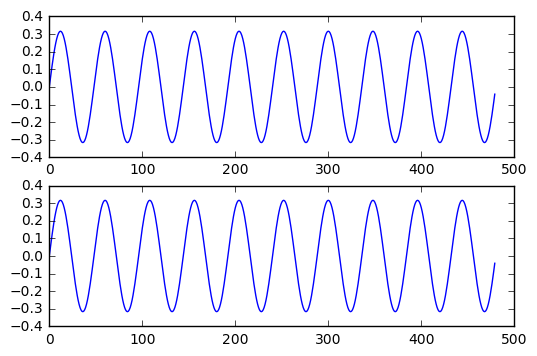

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

psf = pysndfile.PySndfile()
psf.open("wav/sin_48kHzFS_2ch_16bit.wav", "r")
xs = psf.read_frames()

plot_pt = int(0.01 * 48000)

fig = plt.figure(1)

ax = fig.add_subplot(2, 1, 1)
ax.plot(xs[0][:plot_pt])
ax = fig.add_subplot(2, 1, 2)
ax.plot(xs[1][:plot_pt])

plt.show()

psf.close()


# C++のラッパーについて #

* `cdef cppclass`でC++クラスに対するインタフェースを`pxd`上に書く
* このインタフェースを用いる拡張型を書く(`cdef class`)
* C++クラスに対するインタフェースとして定義したコンストラクタをnewを使って生成し、拡張型のメンバ変数でポインタを保持
* 詳しくは https://cython.readthedocs.io/en/latest/src/userguide/wrapping_CPlusPlus.html

## これ以上学ぶための情報 ##

* wiki https://github.com/cython/cython/wiki
* online document
    * 和訳されたものもあるがバージョンが古い(17.1、現在は25.2)ため注意
* オライリーのcython本

## まとめ ##

* Cythonの実行方法と高速化方法について学んだ
* Cラッパー作成方法について学んだ